<a href="https://colab.research.google.com/github/ujwal7/Machine-Learning-Mini-Projects/blob/main/Gender_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Gender Classifier based on Movie Dialogues<h1>

<h3>In this notebook we will classify gender based on movie dialgues. We will be using two datasets for this notebook that is Movie Characters MetaData and Movie Lines data. This notebook basically conveys on how to deal with data sets and what are the generic process we have to follow for data & predictive analytics.<h3>

Importing necessary libraries which will be used in the notebook.

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


<h2>Section 1: Gathering the Data & Data Cleaning.

Importing data and storing it in the data frame variables with the help of pandas and its functions like read_csv(df_lines & df_chars). Checking the output of this step with the help of head functions which displays top 5 rows of the data frame created.

In [2]:
df_lines = pd.read_csv('movie_lines.tsv', sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)
df_char = pd.read_csv('movie_characters_metadata.tsv',sep='\t', error_bad_lines=False,
                       warn_bad_lines=False, header=None)

df_char.head()

,0,1,2,3,4,5
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


Checking the default columns names.

In [3]:
df_char.columns

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')

Changing the column names so that it will be helpful for us in data visualization and in predicitive analytics. Post changing the column names, checking the output with the help of head function.

In [4]:
df_char.columns=['char_Id','char_Name','mov_Id','mov_Name','gender','pos_Credits']
df_char.head()

,char_Id,char_Name,mov_Id,mov_Name,gender,pos_Credits
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


Getting the information of the dataframe which we have created with the help of info command.

In [5]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9034 entries, 0 to 9033
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   char_Id      9034 non-null   object
 1   char_Name    9015 non-null   object
 2   mov_Id       9017 non-null   object
 3   mov_Name     9017 non-null   object
 4   gender       9017 non-null   object
 5   pos_Credits  9017 non-null   object
dtypes: object(6)
memory usage: 423.6+ KB


Checking the shape of the data frame.

In [10]:
df_char.shape

(9034, 6)

Checking the number of null values present in our dataset with the help of isna() and sum() function. 

In [7]:
#Checking the number of null values present in the data set. 
df_char.isna().sum()

char_Id         0
char_Name      19
mov_Id         17
mov_Name       17
gender         17
pos_Credits    17
dtype: int64

Checking the percentage of null values present in respective column in the data set.

In [11]:
#Now we are calculating the percentage of null values present in the data set(column wise).
print('Percentage of Null values with respect to columns in the dataset')
100* df_char.isnull().sum()/len(df_char)

Percentage of Null values with respect to columns in the dataset


char_Id        0.000000
char_Name      0.210317
mov_Id         0.188178
mov_Name       0.188178
gender         0.188178
pos_Credits    0.188178
dtype: float64

Now we will check the type of values present in our target column which is "Gender". It will be done with the help of value_counts() function.

In [12]:
df_char['gender'].value_counts()

?    6008
m    1899
f     921
M     145
F      44
Name: gender, dtype: int64

From the above step, we got the output that is types of values present in "Gender" column and some of them are not required and some of them are duplicates. That is m and f. So we will convert these into M and F and will drop the ? values from the data frame.

In [13]:
#changing the values
df_char.replace('m','M', inplace = True)
df_char.replace('f','F', inplace = True)
df_char['gender'].value_counts()

?    6008
M    2044
F     965
Name: gender, dtype: int64

In [14]:
# dropping passed values
df_char.drop(df_char.index[df_char['gender'] == '?'], inplace = True)
df_char['gender'].value_counts()

M    2044
F     965
Name: gender, dtype: int64

In the post credit column, it had many non unique values, so here we are seggregating it into 1-9 and then to 10+ with the help of lambda function which will excute to value present in post credit column and it will seggregate it based on the condition which we have written.

In [15]:
#Generalizing post credit column
df_char['pos_Credits'] = df_char['pos_Credits'].apply(lambda p: '10+' if not p in ['1', '2', '3', '4', '5', '6', '7', '8', '9'] else p)  ## Label encoding
df_char['pos_Credits'].value_counts()

10+    782
1      497
2      443
3      352
4      268
5      211
6      169
7      125
8      100
9       79
Name: pos_Credits, dtype: int64

Checking the column names of movie lines dataset(df_lines is the dataframe which is created for this).

In [16]:
df_lines.columns

Int64Index([0, 1, 2, 3, 4], dtype='int64')

Changing the column name as per the values which they are having.

In [17]:
df_lines.columns = ['line_ID','char_Id','mov_Id','char_Name','dialogue']
df_lines.head()

,line_ID,char_Id,mov_Id,char_Name,dialogue
0,L1045,u0,m0,BIANCA,They do not!
1,L1044,u2,m0,CAMERON,They do to!
2,L985,u0,m0,BIANCA,I hope so.
3,L984,u2,m0,CAMERON,She okay?
4,L925,u0,m0,BIANCA,Let's go.


Now we are merging the two dataframes which we have created. We are using inner join for the connection and on the columns such as movie id, character id and character name. After merging, we are checking the answer with the help of head function.

In [18]:
df_merge = pd.merge(df_lines,df_char , how='inner', on=['char_Id','mov_Id','char_Name'],
         left_index=False, right_index=False, sort=True,
         copy=False, indicator=False)
df_merge.head()

,line_ID,char_Id,mov_Id,char_Name,dialogue,mov_Name,gender,pos_Credits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,F,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,F,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,F,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,F,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,F,4


Checking the shape of the newly created data frame.

In [19]:
df_merge.shape

(127698, 8)

Checking the  number of null values present in the data frame with the help of isna() and sum() function and then reoving the null values.

In [20]:
df_merge.isna().sum()

line_ID          0
char_Id          0
mov_Id           0
char_Name        0
dialogue       188
mov_Name         0
gender           0
pos_Credits      0
dtype: int64

In [21]:
#removing null values with the help of dropna function
df_merge.dropna()

,line_ID,char_Id,mov_Id,char_Name,dialogue,mov_Name,gender,pos_Credits
0,L1045,u0,m0,BIANCA,They do not!,10 things i hate about you,F,4
1,L985,u0,m0,BIANCA,I hope so.,10 things i hate about you,F,4
2,L925,u0,m0,BIANCA,Let's go.,10 things i hate about you,F,4
3,L872,u0,m0,BIANCA,Okay -- you're gonna need to learn how to lie.,10 things i hate about you,F,4
4,L869,u0,m0,BIANCA,Like my fear of wearing pastels?,10 things i hate about you,F,4
...,...,...,...,...,...,...,...,...
127693,L227685,u998,m65,KATE,Yes.,from dusk till dawn,F,4
127694,L227648,u998,m65,KATE,Creepy guy.,from dusk till dawn,F,4
127695,L227500,u998,m65,KATE,Feel this real wood paneling. That's real wood...,from dusk till dawn,F,4
127696,L227498,u998,m65,KATE,-- you got your shower --,from dusk till dawn,F,4


<h2> Data Visualization<h2>

Creating a function to get the bar values which we can put it in countplots.

In [40]:
def annot_plot(ax,w,h):                                    # function to add data to plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for p in ax.patches:
        ax.annotate('{0:.1f}'.format(p.get_height()), (p.get_x()+w, p.get_height()+h))

Visualizing the number of Male and Female present in our merged dataset. As per the graph, we can easily interpret that the dataset contains more dialogues of Males than Females.

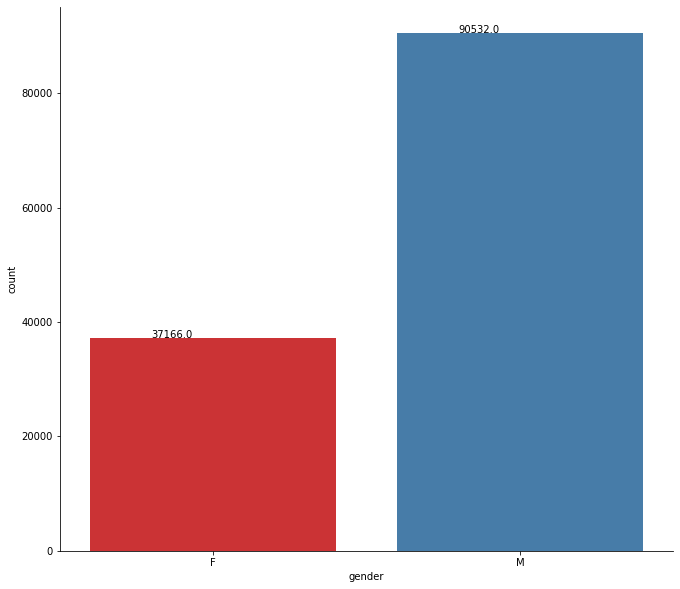

In [46]:
plt.figure(figsize=(11,10))
ax = sns.countplot(x='gender',data=df_merge,palette='Set1')
annot_plot(ax,0.2,1)
plt.show()

Visualizing the number of unique values present in pos_credit column.

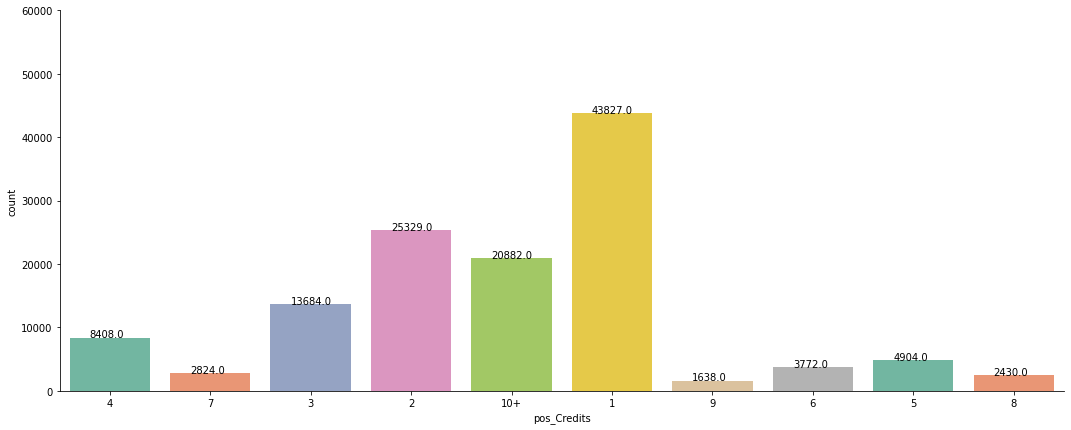

In [43]:

plt.figure(figsize=(18,7))
#Setting the limits for countplot shown below.
plt.ylim(0,60000)
#Creating a countplot to show 'pos_Credits'
ax = sns.countplot(x='pos_Credits',data=df_merge,palette='Set2')
#ploting the graph.
annot_plot(ax,0.2,1)
plt.show()


<h2> Feature Engineering<h2>

Now as our data set is quite big in terms of number of records. We will classify the data on our sample set. Sample set is basically a subset of the data set which we have. We will be using 20 percent of the sampled data from our data set for preiction.

In [22]:
# here you get 20 % of the rows
samp_df = df_merge.sample(frac = 0.2)
samp_df.shape

(25540, 8)

Using Natural Language Processing for the dialogue column.

In [24]:
#Initialising the WorNetLemmatizer Object
wordnet_lemmatizer = WordNetLemmatizer()
def apply_nlp( dialogue ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", str(dialogue))
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))   
    
    # Use lemmatization and remove stop words
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops]   
    #
    # Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))

samp_df['processed_dialogue'] = samp_df['dialogue'].apply(apply_nlp)
samp_df[['dialogue','processed_dialogue']].tail()

,dialogue,processed_dialogue
7025,Baron we must have gone a hundred miles an hou...,baron must gone hundred mile hour least
90651,C'mon Jennifer he's just another North-Side ja...,c mon jennifer another north side jag mouth
97950,Hmm. Not bad.,hmm bad
22984,...Later.,later
77779,Yeah. Oh yeah. Yeah I see. I guess-,yeah oh yeah yeah see guess


Applying the processed dialogue to Term Frequency-Inverse Document Frequency to convert into an arrays.(Bascially we are changing Categorical values to numercial values)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = samp_df['processed_dialogue']
X = tfidf.fit_transform(X).toarray()

Replacing values of Males(M) and Females(F) to 0 & 1 respectively.

In [27]:
samp_df.replace('M','0',inplace = True)
samp_df.replace('F','1',inplace = True)
y = samp_df['gender']
y = y.values

<h2>Predictive Analytics<h2>

Using train_test_Split to divide our data into training and testing set.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
print('X_train size: {}, X_test size: {}'.format(X_train.shape, X_test.shape))

X_train size: (20432, 12940), X_test size: (5108, 12940)


Initializing model objects. We will be using sevral models and will check in which model we get higher accuracy.

In [29]:
nb_classifier = MultinomialNB()
svc_classifier = LinearSVC()
log_classifier = LogisticRegression()
rf_classifier = RandomForestClassifier()

Fitting the trained data in the model objects with the help of fit function.

In [30]:
nb_classifier.fit(X_train, y_train)
svc_classifier.fit(X_train, y_train)
log_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

Predicting the values/gender based on our test data with the help of predict command storing it into variables such as nb_y_pred.

In [31]:
nb_y_pred = nb_classifier.predict(X_test)
svc_y_pred = svc_classifier.predict(X_test)
log_y_pred = log_classifier.predict(X_test)
rf_y_pred = rf_classifier.predict(X_test)

Checking the accuracy score of the models with help of accracy score which is in metrics package which is present in sklearn.

In [33]:
from sklearn.metrics import accuracy_score
score1 = accuracy_score(y_test, nb_y_pred)
score2 = accuracy_score(y_test, svc_y_pred)
score3 = accuracy_score(y_test, log_y_pred)
score4 = accuracy_score(y_test, rf_y_pred)
print("---- Score of ML Models ----")
print("Accuracy score of Multinomial NB is: {}%".format(round(score1*100,2)))
print("Accuracy score of Linear SVM Classifier is: {}%".format(round(score2*100,2)))
print("Accuracy score of Logistic Regression model is: {}%".format(round(score3*100,2)))
print("Accuracy score of Random Forest Classifier is: {}%".format(round(score4*100,2)))

---- Score of ML Models ----
Accuracy score of Multinomial NB is: 70.4%
Accuracy score of Linear SVM Classifier is: 68.64%
Accuracy score of Logistic Regression model is: 70.91%
Accuracy score of Random Forest Classifier is: 68.89%


Checking the classification report of the models with help of classification report function. It will basically give us the F1 score, precision and recall result.

In [34]:
print('classification_report of Multinomial NB is: ')
print(classification_report(y_test,nb_y_pred))
print('classification_report of Linear SVM is: ')
print(classification_report(y_test,svc_y_pred))
print('classification_report of Logistic Regression model is: ')
print(classification_report(y_test,log_y_pred))
print('classification_report of Random Forest Classifier model is: ')
print(classification_report(y_test,rf_y_pred))

classification_report of Multinomial NB is: 
              precision    recall  f1-score   support

           0       0.71      0.99      0.82      3602
           1       0.46      0.03      0.05      1506

    accuracy                           0.70      5108
   macro avg       0.59      0.51      0.44      5108
weighted avg       0.64      0.70      0.60      5108

classification_report of Linear SVM is: 
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      3602
           1       0.42      0.17      0.24      1506

    accuracy                           0.69      5108
   macro avg       0.57      0.53      0.52      5108
weighted avg       0.63      0.69      0.64      5108

classification_report of Logistic Regression model is: 
              precision    recall  f1-score   support

           0       0.71      0.98      0.83      3602
           1       0.57      0.05      0.10      1506

    accuracy                           0

<h2>Obersvation:<h2> From the above output we can clearly depict that random forest model has given the highest accuracy and Multinomial NB has also performed simiarly. I hope that by following this notebook, you would have got the fair idea on how to approach a problem or use cases and go step by step which in turn will yeild good results.
Happy Learning!!